In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
reit = screen_funds('Alternatives')
commodity = screen_funds('Commodities', min_assets=.2)
print(len(reit), len(commodity))
quote = Quote(reit + commodity, 60, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

12 21
from 2019-05-15 to 2019-07-12 - 33


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

24


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
PALL,36,0.456380,0.521417,0.860048,15.164162,2.616506
IAU,36,0.256151,0.397516,0.624414,9.193551,2.716592
BAR,36,0.254904,0.393468,0.627670,9.210523,2.700990
SGOL,36,0.254631,0.395103,0.624379,9.155664,2.692057
GLD,36,0.253250,0.391102,0.627236,9.102050,2.667662
GLTR,36,0.231683,0.327557,0.683078,7.681360,2.228544
PSLV,36,0.216934,0.372603,0.560912,6.603772,2.830190
XLRE,36,0.132590,0.418809,0.297638,3.943042,4.835459
DBA,36,0.115117,0.264700,0.404912,6.628783,2.544381


evicted PSLV 0.877 -0.397
evicted COMT 0.260 -0.246
evicted RWO 0.702 -0.330
evicted PALL 0.290 -0.025
retry backlogs ['RWR', 'VNQ', 'GLTR', 'USRT', 'IAU', 'XLRE', 'GLD', 'IYR', 'SCHH', 'REET', 'SLV', 'SIVR', 'DJP', 'SGOL', 'ICF', 'RWX', 'REM'] at 0.905/-0.51 - 1.276
evicted SLV 0.905 -0.307
evicted REET 0.678 -0.295
evicted DJP 0.259 -0.075
retry backlogs ['SGOL', 'VNQ', 'RWR', 'USRT', 'IAU', 'XLRE', 'SIVR', 'IYR', 'RWX', 'GLTR', 'GLD', 'SCHH', 'ICF', 'REM'] at 0.910/-0.52 - 1.276
evicted SIVR 0.900 -0.300
evicted ICF 0.517 -0.189
retry backlogs ['SGOL', 'USRT', 'IAU', 'BAR', 'VNQ', 'RWR', 'RWX', 'IYR', 'GLTR', 'XLRE', 'SCHH', 'REM'] at 0.915/-0.53 - 1.276
evicted RWR 0.579 -0.237
retry backlogs ['USRT', 'SGOL', 'IYR', 'VNQ', 'IAU', 'GLTR', 'GLD', 'RWX', 'SCHH', 'XLRE', 'REM'] at 0.920/-0.54 - 1.276
evicted SCHH 0.581 -0.236
retry backlogs ['SGOL', 'USRT', 'IYR', 'IAU', 'VNQ', 'GLTR', 'GLD', 'RWX', 'XLRE', 'REM'] at 0.925/-0.55 - 1.276
evicted XLRE 0.536 -0.131
evicted REM 0.521 -0.54

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,36.0,0.135858,0.100675,-0.113329,0.104632,0.152623,0.190668,0.286241,1.270635,6.114236,0.971112
BAR,36.0,0.254904,0.393468,-0.500851,0.023523,0.175521,0.542126,1.145879,0.627670,9.210523,2.700990
VNQI,36.0,0.106962,0.198112,-0.217406,-0.047167,0.103695,0.279988,0.465242,0.499847,4.382233,1.474619
DBA,36.0,0.115117,0.264700,-0.358080,-0.059998,0.036916,0.374396,0.723039,0.404912,6.628783,2.544381


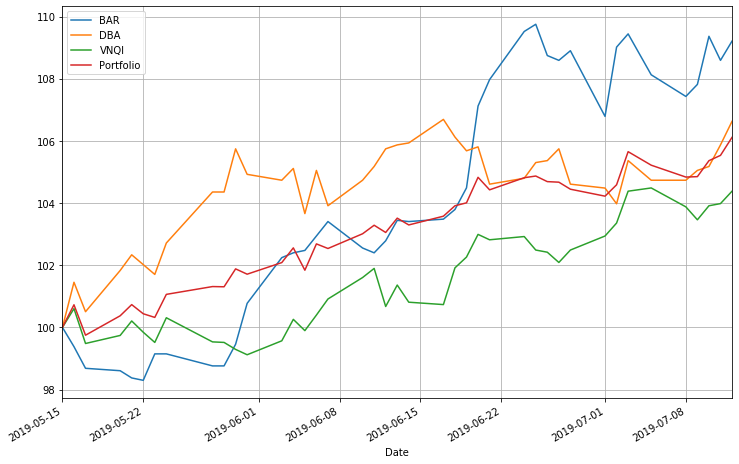

In [4]:
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(_lambda=1)
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(_lambda=1))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)